*   Name: Devin Augustin
*   NIM: 2440094352

In [ ]:
from functools import partial
import os
import glob
import cv2
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#1. Load the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip /content/drive/MyDrive/Colab/UAS_DLO/Aerial-Image-Dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Forest Segmented/Forest Segmented/masks/119079_mask_73.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/119079_mask_77.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/119079_mask_78.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/119079_mask_80.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/119079_mask_81.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/119079_mask_87.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/119079_mask_88.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/122104_mask_00.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/122104_mask_01.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/122104_mask_03.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/122104_mask_04.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/122104_mask_11.jpg  
  inflating: Forest Segmented/Forest Segmented/masks/122104_m

In [ ]:
images_dir = '/content/Forest Segmented/Forest Segmented/images/*jpg'
masks_dir = '/content/Forest Segmented/Forest Segmented/masks/*.jpg'

In [ ]:
images_name = sorted(glob.glob(images_dir), key=lambda x: x.split('.')[0])
masks_name = sorted(glob.glob(masks_dir), key=lambda x: x.split('.')[0])

In [ ]:
def img_resize(image, y_dim, x_dim):
    resized_img = cv2.resize(image, (y_dim,x_dim))
    return resized_img

In [ ]:
image_array = []
mask_array = []

for image in images_name:
    img = cv2.imread(image, -1)
    img = img_resize(img, 128, 128)
    image_array.append(img)
    
image_array = np.array(image_array)

for mask in masks_name:
    msk = cv2.imread(mask, 0)
    msk = img_resize(msk, 128, 128)
    mask_array.append(msk)
    
mask_array = np.array(mask_array)

In [ ]:
def normalize_array(arr):
    return arr/255.0

normImage = normalize_array(image_array)
normMask = normalize_array(mask_array)

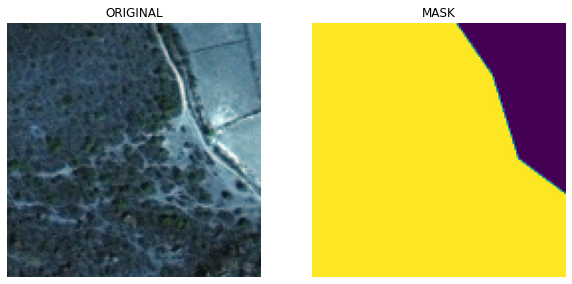

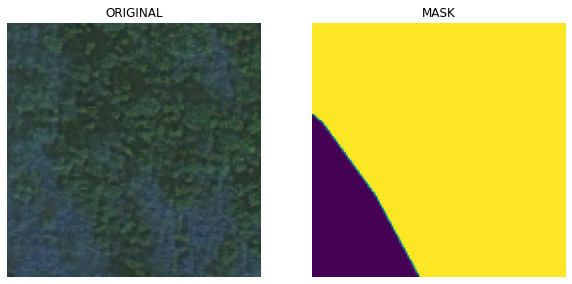

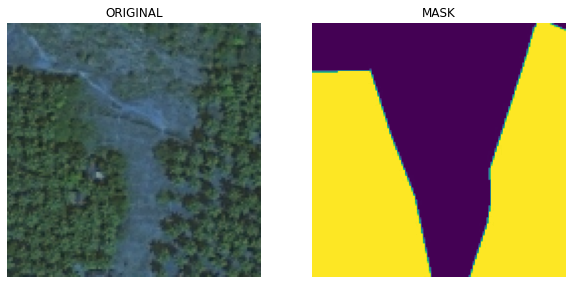

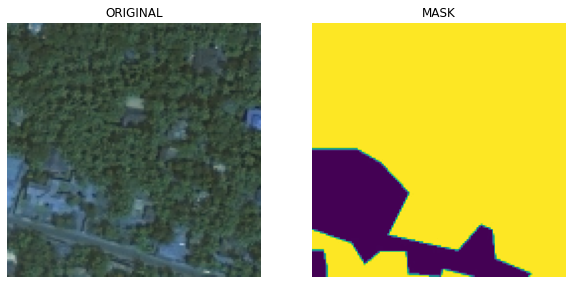

In [ ]:
%matplotlib inline
iterate = 0
while iterate < 4:
  randNum = random.randint(0,500)
  fig, axs = plt.subplots(1,2,figsize=(10,10))

  axs[0].set_title("ORIGINAL")
  axs[0].axis("off")
  axs[0].imshow(normImage[randNum])

  axs[1].set_title("MASK")
  axs[1].axis("off")
  axs[1].imshow(normMask[randNum])
  iterate += 1

#**Split the data**

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(normImage, normMask, test_size=0.2, random_state=23)

#**Build the model**

For the architecture, I'm going to use the U-net model. I chose this architecture because it's simple and efficient compared to other models. It's also very effective for handling semantic segmentation task. This architecture uses both upsampling and downsampling layers to preserve both spatial and semantic information in the image.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model


def unet_model(input_shape=(128, 128, 3)):
    inputs = keras.Input(shape=input_shape)
    # Downsampling path
    c1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    
    c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    
    c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)
    
    c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c4)
    
    # Upsampling path
    u1 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c4)
    u1 = layers.concatenate([u1, c3])
    c5 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u1)
    c5 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c5)
    
    u2 = layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c5)
    u2 = layers.concatenate([u2, c2])
    c6 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(u2)
    c6 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(c6)
    
    u3 = layers.Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same')(c6)
    u3 = layers.concatenate([u3, c1])
    c7 = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(u3)
    c7 = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(c7)

    output = Conv2D(1, 1, activation='sigmoid')(c7)
    return tf.keras.Model(inputs=inputs, outputs=output)

In [ ]:
model = unet_model()

model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 8)  224         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 8)  584         ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 64, 64, 8)    0           ['conv2d_1[0][0]']           

#**Train the model**

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1)

epochs = 50
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=epochs, callbacks=[early_stopping, lr_reduce])

Epoch 1/50
128/128 [==============================] - 267s 2s/step - loss: 0.6475 - accuracy: 0.6124 - val_loss: 0.5909 - val_accuracy: 0.7046 - lr: 0.0010
Epoch 2/50
128/128 [==============================] - 266s 2s/step - loss: 0.5741 - accuracy: 0.7069 - val_loss: 0.5534 - val_accuracy: 0.7248 - lr: 0.0010
Epoch 3/50
128/128 [==============================] - 266s 2s/step - loss: 0.5516 - accuracy: 0.7257 - val_loss: 0.5212 - val_accuracy: 0.7484 - lr: 0.0010
Epoch 4/50
128/128 [==============================] - 266s 2s/step - loss: 0.5122 - accuracy: 0.7486 - val_loss: 0.5510 - val_accuracy: 0.7120 - lr: 0.0010
Epoch 5/50
128/128 [==============================] - 265s 2s/step - loss: 0.5095 - accuracy: 0.7494 - val_loss: 0.4959 - val_accuracy: 0.7640 - lr: 0.0010
Epoch 6/50
128/128 [==============================] - 273s 2s/step - loss: 0.4893 - accuracy: 0.7614 - val_loss: 0.4702 - val_accuracy: 0.7759 - lr: 0.0010
Epoch 7/50
128/128 [==============================] - 272s 2s/st

#**Result**

1/1 [==============================] - 0s 33ms/step


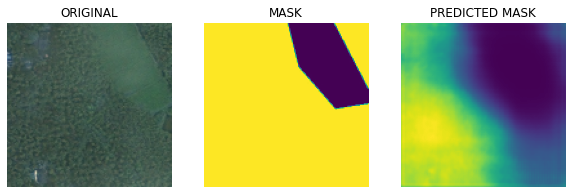

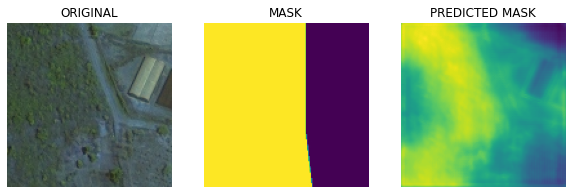

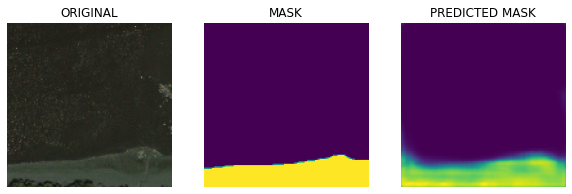

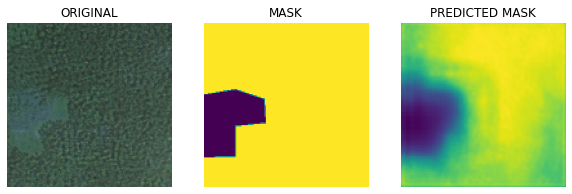

In [ ]:
iterate = 0

while iterate < 4:
  fig, axs = plt.subplots(1,3,figsize=(10,10))
  randNum = random.randint(0,500)

  normImage = x_test[randNum]
  axs[0].set_title("ORIGINAL")
  axs[0].axis("off")
  axs[0].imshow(normImage)

  normMask = y_test[randNum]
  axs[1].set_title("MASK")
  axs[1].axis("off")
  axs[1].imshow(normMask)

  normImage = np.expand_dims(normImage, axis=0)
  prediction = model.predict(normImage).reshape(128,128)
  axs[2].set_title("PREDICTED MASK")
  axs[2].axis("off")
  axs[2].imshow(prediction)
  
  iterate += 1

#**Model with hard attention added**
I chose hard attention because it's faster to compute and provide more interpretable results.

In [ ]:
def unet_model_attention(input_shape=(128, 128, 3)):
    inputs = keras.Input(shape=input_shape)
    # Downsampling path
    c1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    
    c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    
    c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)
    
    c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c4)
    
    # Upsampling path
    u1 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c4)
    attention1 = layers.Conv2D(1, 1, activation='sigmoid')(c3)
    u1 = layers.multiply([u1, attention1])
    u1 = layers.concatenate([u1, c3])
    c5 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u1)
    c5 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c5)
    
    u2 = layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c5)
    attention2 = layers.Conv2D(1, 1, activation='sigmoid')(c2)
    u2 = layers.multiply([u2, attention2])
    u2 = layers.concatenate([u2, c2])
    c6 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(u2)
    c6 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(c6)
    
    u3 = layers.Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same')(c6)
    attention3 = layers.Conv2D(1, 1, activation='sigmoid')(c1)
    u3 = layers.multiply([u3, attention3])
    u3 = layers.concatenate([u3, c1])
    c7 = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(u3)
    c7 = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(c7)

    output = Conv2D(1, 1, activation='sigmoid')(c7)
    return tf.keras.Model(inputs=inputs, outputs=output)

In [ ]:
model_attention = unet_model_attention()

model_attention.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])

In [ ]:
model_attention.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_51 (Conv2D)             (None, 128, 128, 8)  224         ['input_9[0][0]']                
                                                                                                  
 conv2d_52 (Conv2D)             (None, 128, 128, 8)  584         ['conv2d_51[0][0]']              
                                                                                                  
 max_pooling2d_12 (MaxPooling2D  (None, 64, 64, 8)   0           ['conv2d_52[0][0]']        

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1)

epochs = 50
history_attention = model_attention.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=epochs, callbacks=[early_stopping, lr_reduce])

Epoch 1/50
128/128 [==============================] - 267s 2s/step - loss: 0.4133 - accuracy: 0.8042 - val_loss: 0.4191 - val_accuracy: 0.8044 - lr: 9.0000e-05
Epoch 2/50
128/128 [==============================] - 266s 2s/step - loss: 0.4132 - accuracy: 0.8043 - val_loss: 0.4163 - val_accuracy: 0.8065 - lr: 9.0000e-05
Epoch 3/50
128/128 [==============================] - 266s 2s/step - loss: 0.4144 - accuracy: 0.8031 - val_loss: 0.4160 - val_accuracy: 0.8063 - lr: 9.0000e-05
Epoch 4/50
128/128 [==============================] - 267s 2s/step - loss: 0.4119 - accuracy: 0.8049 - val_loss: 0.4168 - val_accuracy: 0.8067 - lr: 9.0000e-05
Epoch 5/50
128/128 [==============================] - 266s 2s/step - loss: 0.4121 - accuracy: 0.8049 - val_loss: 0.4156 - val_accuracy: 0.8065 - lr: 9.0000e-05
Epoch 6/50
128/128 [==============================] - 265s 2s/step - loss: 0.4109 - accuracy: 0.8052 - val_loss: 0.4143 - val_accuracy: 0.8070 - lr: 9.0000e-05
Epoch 7/50
128/128 [====================

#**Result**

1/1 [==============================] - 0s 33ms/step


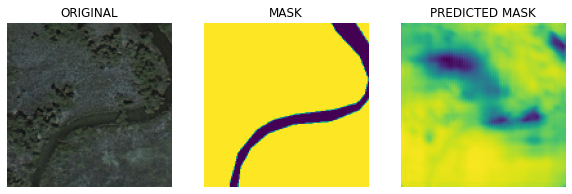

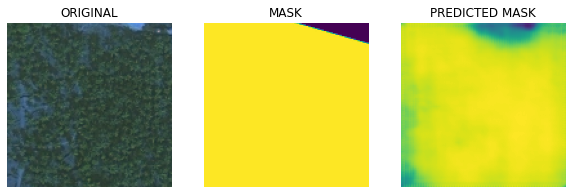

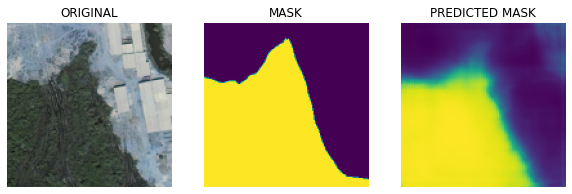

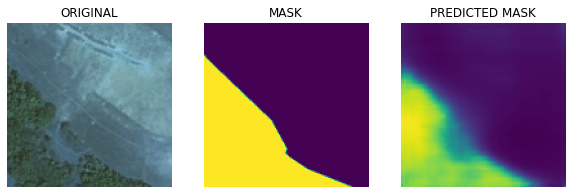

In [ ]:
iterate = 0

while iterate < 4:
  fig, axs = plt.subplots(1,3,figsize=(10,10))
  randNum = random.randint(0,500)

  normImage = x_test[randNum]
  axs[0].set_title("ORIGINAL")
  axs[0].axis("off")
  axs[0].imshow(normImage)

  normMask = y_test[randNum]
  axs[1].set_title("MASK")
  axs[1].axis("off")
  axs[1].imshow(normMask)

  normImage = np.expand_dims(normImage, axis=0)
  prediction = model_attention.predict(normImage).reshape(128,128)
  axs[2].set_title("PREDICTED MASK")
  axs[2].axis("off")
  axs[2].imshow(prediction)
  
  iterate += 1

In [ ]:
loss, accuracy, val_loss, val_accuracy, val_iou = history.history.values()

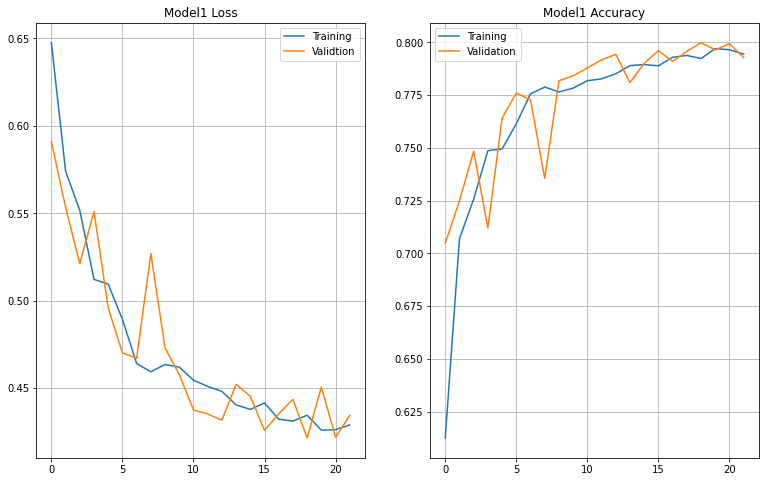

In [ ]:
plt.figure(figsize=(20,8))

plt.subplot(1,3,1)
plt.title("Model1 Loss")
plt.plot(loss, label="Training")
plt.plot(val_loss, label="Validtion")
plt.legend()
plt.grid()

plt.subplot(1,3,2)
plt.title("Model1 Accuracy")
plt.plot(accuracy, label="Training")
plt.plot(val_accuracy, label="Validation")
plt.legend()
plt.grid()

plt.show()

In [ ]:
loss, accuracy, val_loss, val_accuracy, val_iou = history_attention.history.values()

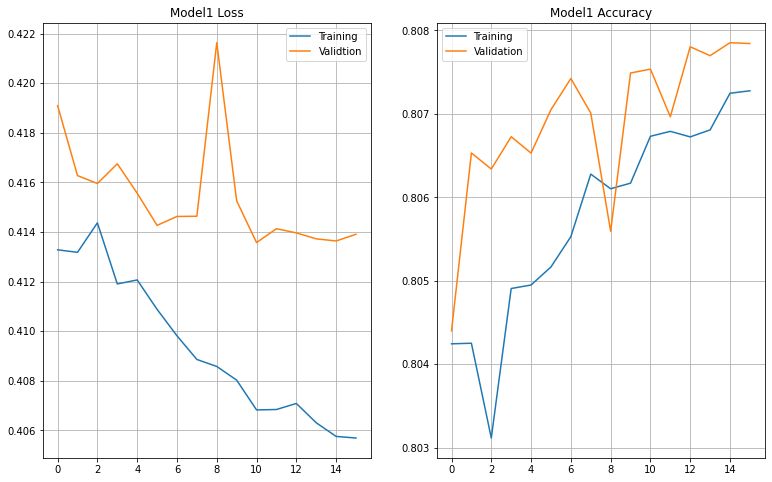

In [ ]:
plt.figure(figsize=(20,8))

plt.subplot(1,3,1)
plt.title("Model1 Loss")
plt.plot(loss, label="Training")
plt.plot(val_loss, label="Validtion")
plt.legend()
plt.grid()

plt.subplot(1,3,2)
plt.title("Model1 Accuracy")
plt.plot(accuracy, label="Training")
plt.plot(val_accuracy, label="Validation")
plt.legend()
plt.grid()

plt.show()